# 0. Imports

### 0.1 Libs

In [1]:
import warnings
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns
import nbformat


from IPython.display        import Image
from scipy                  import stats            as ss
from plotly                 import express          as px
from matplotlib             import pyplot           as plt
from sklearn                import cluster          as c
from sklearn                import metrics          as m

from yellowbrick.cluster    import KElbowVisualizer

### 0.2 Helper Functions

In [2]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [3]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [4]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


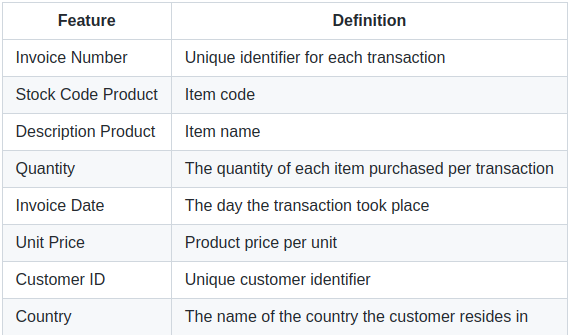

In [7]:
Image('../image/features_description.png')

### 1.2 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [10]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


### 1.5 Change Types

In [11]:
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.6 Descriptive Statistics

# 2. Feature Engineering

### 2.1 News Features

In [13]:
df2 = df1.copy()

df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [14]:
# Data Reference
df_ref = df2.drop (['invoice_no', 'stock_code', 'description',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [15]:
# Gross Revenue (quantity * unit_price)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')


In [16]:
# Recency - last day purchase

# A última data do dataset vai se tornar a refência da feature recency
df2['invoice_date'].max()


Timestamp('2011-12-09 12:50:00')

In [17]:
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.head()

,customer_id,invoice_date,recency_days
0,12346,2011-01-18 10:17:00,325
1,12347,2011-12-07 15:52:00,1
2,12348,2011-09-25 13:13:00,74
3,12349,2011-11-21 09:51:00,18
4,12350,2011-02-02 16:01:00,309


In [18]:
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

In [19]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
dtype: int64

In [20]:
# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')

In [21]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
dtype: int64

# 3. Data Filtering

In [22]:
df3 = df_ref.copy()

# 4. Exploratory Data Analysis

In [23]:
df4 = df3.copy()

# 5. Data Preparation

In [24]:
df5 = df4.copy()

# 6. Feature Selection

In [25]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [26]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,301,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,329,6


In [27]:
df7 = df6.drop(columns = ['customer_id'])

In [28]:
clusters = [2, 3, 4, 5, 6]

### 7.1 Within-Cluster Sum of Square (WSS)

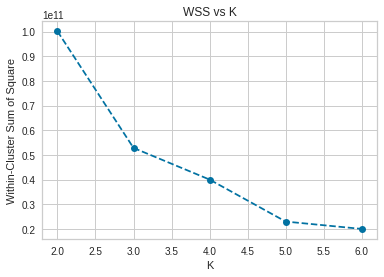

In [29]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init = 'random', 
                      n_clusters=k, 
                      n_init=10, 
                      max_iter = 300, 
                      random_state= 42)
    
    # model training
    kmeans.fit( df7 )

    #  validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');


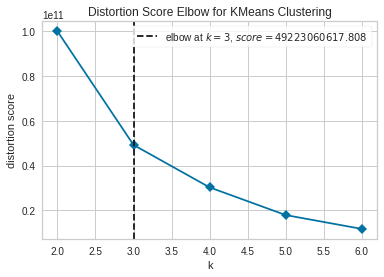

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.2 Silhouette Score

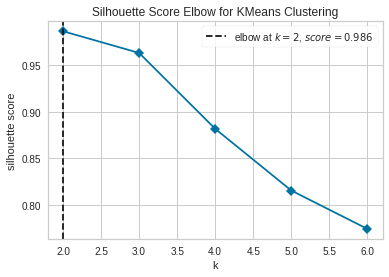

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [31]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          metric='silhouette',
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

# 8. Machine Learning Modelling

### 8.1 K-Means

In [43]:
df7.head()

,gross_revenue,recency_days,invoice_no
0,5288.63,301,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,329,6


In [47]:
# model definition
k=3
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(df7)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [48]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(df7, labels, metric='euclidean')))

WSS Value:52830436382.66513
SS Value: 0.9494677108004962


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [54]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,301,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,329,6,0


In [55]:
df9['cluster'].value_counts()

0    4335
2      31
1       6
Name: cluster, dtype: int64

In [51]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

### 9.2 Cluster Profile

In [56]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,301,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,329,6,0


In [65]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,91.723414,4.614533
1,1,6,0.137237,182181.981667,6.666667,89.000000
2,2,31,0.709058,40543.517742,12.806452,53.290323


Cluster 01 (Candidado a Insider):
- Total Customers: 6 (0,14% of total)
- Avg Recency: 7 days
- Avg frequency: 89 purchase
- Avg Revenue: $ 182,181.98

Cluster 02:
- Total Customers: 31 (0,71% of total)
- Avg Recency: 14 days
- Avg frequency: 53 purchase
- Avg Revenue: $ 40,543.52

Cluster 03:
- Total Customers: 4,335 (99% of total)
- Avg Recency: 92 days
- Avg frequency: 5 purchase
- Avg Revenue: $ 1,372.58

# 10. Deploy To Production